In [72]:
import pandas as pd

pd.options.plotting.backend = "plotly"

In [73]:
url_template = "https://www.wahlrecht.de/umfragen/{}.htm"
survey_institutes = [
    "allensbach",
    "emnid",
    "forsa",
    "politbarometer",
    "gms",
    "dimap",
    "insa",
    "yougov",
]

In [109]:
def get_data_from_wahlrecht_de(institute):
    print(institute)
    url = url_template.format(institute)

    table = pd.read_html(url)[1]
    table = table.rename({"Unnamed: 0": "Datum"}, axis=1)

    good_lines = table["Datum"].str.match("\d\d\.\d\d\.\d\d\d\d").fillna(False)
    table = table.loc[good_lines]

    bad_columns = ["Unnamed", "Sonstige", "Befragte", "Zeitraum", "Nichtwähler"]

    def is_good_column(column):
        for bad in bad_columns:
            if bad in column:
                return False
        return True

    table = table[[col for col in table.columns if is_good_column(col)]]

    table["Datum"] = pd.to_datetime(table["Datum"], dayfirst=True)

    percentage_columns = [
        col
        for col in table.columns
        if table[col].dtype == "O"
        if "%" in table[col].iloc[0] or "–" in table[col].iloc[0]
    ]

    for col in percentage_columns:
        table[col] = (
            table[col].str.rstrip(" %").str.replace(",", ".").str.replace("–", "0")
        )
        table[col] = pd.to_numeric(table[col], errors="coerce") / 100

    table = table.dropna()
    table["Institut"] = institute
    return table

In [110]:
data = pd.concat(
    [get_data_from_wahlrecht_de(institute) for institute in survey_institutes],
    axis=0,
)

allensbach
emnid
forsa
politbarometer
gms
dimap
insa
yougov


In [113]:
data = data.sort_values(by="Datum")

In [114]:
data.iloc[-10:]

,Datum,CDU/CSU,SPD,GRÜNE,FDP,LINKE,AfD,Institut,PIRATEN,FW
3,2021-07-31,0.270,0.170,0.180,0.130,0.060,0.110,insa,0.0,0.000
2,2021-08-02,0.275,0.180,0.180,0.130,0.070,0.110,insa,0.0,0.000
1,2021-08-03,0.260,0.160,0.200,0.130,0.060,0.100,forsa,NaN,NaN
1,2021-08-04,0.240,0.180,0.220,0.130,0.060,0.110,emnid,NaN,NaN
0,2021-08-05,0.270,0.180,0.190,0.120,0.060,0.100,dimap,NaN,NaN
1,2021-08-07,0.260,0.180,0.180,0.120,0.070,0.110,insa,0.0,0.000
0,2021-08-09,0.255,0.175,0.175,0.125,0.065,0.115,insa,0.0,0.035
0,2021-08-11,0.220,0.190,0.210,0.120,0.070,0.110,emnid,NaN,NaN
0,2021-08-11,0.230,0.190,0.200,0.120,0.070,0.100,forsa,NaN,NaN
0,2021-08-13,0.260,0.190,0.190,0.110,0.070,0.110,politbarometer,NaN,NaN


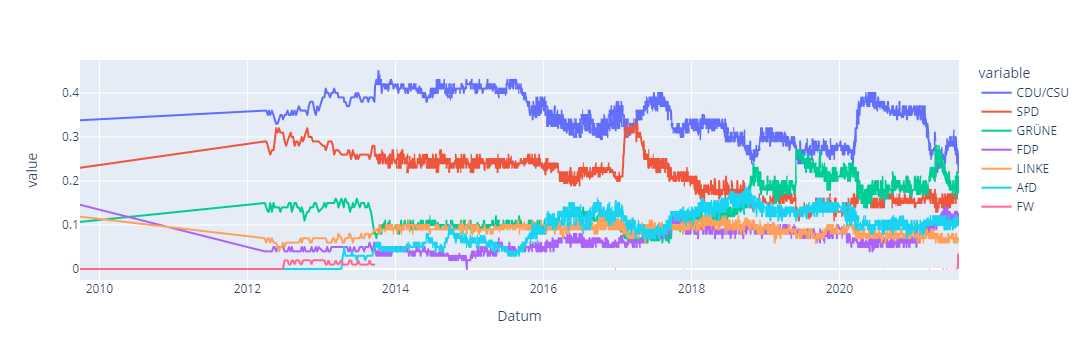

In [115]:
data.plot(x="Datum", y=["CDU/CSU", "SPD", "GRÜNE", "FDP", "LINKE", "AfD", "FW"])